In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from scipy.ndimage import convolve
from tqdm import tqdm
import time

class lightningSimulation:
    def __init__(self,
                 width=80,
                 height=80,
                 n=1.2,
                 rod_height=0,
                 rod_xpos=0.5,
                 config_type='',
                 debug=False,
                 pot_calc_iters = 300,
                 recalc_delay = 50,
                 neighborhood_type = '',
                 subgrid_radius = 6):

        # Store grid dimensions
        self.width = width
        self.height = height

        # Create grid and set all to -1
        self.grid = np.ones(shape=(height, width))
        self.grid *= -1

        # The lightning downwards-tendency parameter
        self.n = n

        # Number of update steps
        self.steps = 0

        # To debug or not
        self.debug = debug
        self.display_interval = 75

        # The current electric potential
        self.potential = self.grid

        # The number of diffusion iterations to do during the major recalculations
        self.pot_calc_iters = pot_calc_iters

        # The number of updates to do between each major recalculation
        self.recalc_delay = recalc_delay

        self.subgrid_radius = subgrid_radius

        # Lightning distance to ground
        self.dist_to_ground = self.height

        self.struck_ground = False
        
        self.structure_neighbors = []

        self.time_spent_potential = 0
        self.time_spent_other = 0

        # Neighborhood types
        diagonal_neighbors = [(1, 1), (-1, 1), (1, -1), (-1, -1)]
        neumann_neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        moore_neighbors = diagonal_neighbors.copy()
        moore_neighbors.extend(neumann_neighbors)

        if neighborhood_type == 'diagonal':
            self.neighborhood_type = diagonal_neighbors
        elif neighborhood_type == 'moore':
            self.neighborhood_type = moore_neighbors
        elif neighborhood_type == 'neumann':
            self.neighborhood_type = neumann_neighbors
        else:
            self.neighborhood_type = neumann_neighbors

        # Setup initial potential
        gradient = np.linspace(1/self.height, 1, self.height)

        # Reshape the gradient to match the dimensions of the array
        gradient = gradient[:, np.newaxis]

        # Tile the gradient to match the width of the array
        gradient = np.tile(gradient, (1, self.width))

        self.potential = gradient

        # Setup the environment
        self.setup_environment(config_type, rod_height, rod_xpos)

    def setup_environment(self, config_type='', rod_height=0, rod_xpos=0.5):
        '''
        Creates the enviroment of
            1. lightning start position, where self.grid == 0
            2. cells which are considered ground, where self.grid == 1
        Unkown electric potential is where self.grid == -1
        '''

        # If setup is circle
        if config_type == 'circle':
            # Set the origin at the center
            self.grid[self.height//2, self.width//2] = 0
            self.newest_neighbor = (self.height//2, self.width//2)

            # Set a circle of radius width // 2 to 1
            mask = (self.create_circle(self.width//2) == 1)
            self.grid[mask] = 1
        else:
            # Potential of 1 represents ground
            # Set ground to potential 1
            self.grid[-1, :] = 1
            for i in range(rod_height):
                self.grid[-1-i, int(self.width*rod_xpos)] = 1

            self.expand_lightning((0, int(self.width*rod_xpos)))
            
    def expand_lightning(self, pos):
        

        # Mark cell as newest neighbor
        self.newest_neighbor = pos
        
        # Mark square as lightning in grid
        self.grid[pos[0], pos[1]] = 0
        self.potential[pos[0], pos[1]] = 0

        # Update the electric potential in air
        self.potential = self.calc_electric_pot()

    def create_circle(self, r):
        d = 2*r
        x, y = np.indices((d, d))
        r -= 1
        return (np.abs(np.hypot(r - x, r - y)-r) < 0.5).astype(int)

    def display_state(self, this_grid=None, lightning=False):
        # Plot a figure displaying the environment
        if this_grid is None:
            this_grid = self.grid

        # If display lightning
        if lightning:
            # Display 0 potentials as yellow
            masked_arr = np.ma.masked_where(this_grid == 0, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='yellow')
        else:
            # Otherwise it's plotting potential
            # Otherwise set -1 as gray
            masked_arr = np.ma.masked_where(this_grid == -1, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='gray')

        # Display
        plt.figure(figsize=(16, 10))
        plt.imshow(masked_arr, cmap=cmap)
        plt.colorbar()

        if not lightning:
            plt.contour(this_grid, colors='white')
        plt.show()

    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.height, desc="How close the lightning is to the ground", unit="cells")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.height - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.height - self.newest_neighbor[0]
                    progress_bar.update(1)

    def check_struck_ground(self):
        # Look at all neighbors of newest neighbor
        for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            if self.newest_neighbor[0] > 5:
                # If within bounds
                if self.newest_neighbor[0]+dy > 0 and self.newest_neighbor[0]+dy < self.height and self.newest_neighbor[1]+dx > 0 and self.newest_neighbor[1]+dx < self.width:
                    # If one neighbor is ground (potential 1), break while loop
                    if self.grid[self.newest_neighbor[0]+dy, self.newest_neighbor[1]+dx] == 1:
                        self.struck_ground = True

    def update(self):

        # Debug
        if self.debug and self.steps % self.display_interval == 0:
            print("The lightning structure")
            self.display_state(lightning=True)

        mark = time.time()

        # Keep track of neighbors
        neighbors = {}
        # For each cell
        for x in range(self.width):
            for y in range(self.height):
                # If this cell is part of the lightning structure
                if self.grid[y, x] == 0:
                    # For each neighbor
                    for dy, dx in self.neighborhood_type:
                        # If neighbor is within bounds
                        if y+dy >= 0 and y+dy < self.height and x+dx >= 0 and x+dx < self.width:
                            # If neighbor hasn't been counted before and it's not a part of the lightning
                            if (y+dy, x+dx) not in neighbors.keys() and self.grid[y+dy, x+dx] != 0:
                                # Add their electric potential to dictionary
                                neighbors[(y+dy, x+dx)] = self.potential[y+dy, x+dx]



        # Raise each weight to the power of n
        # weights = [val**self.n for val in neighbors.values()]
        weights = np.array(list(neighbors.values()))**self.n
        
        
        # Ensure they sum up to 1
        #weights = np.array(weights)/np.sum(weights)
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(neighbors.keys()), weights)[0]

        self.time_spent_other += time.time() - mark
        mark = time.time()
        self.expand_lightning(chosen_cell)
        self.time_spent_potential += time.time() - mark
        
        self.check_struck_ground()

        self.steps += 1


    def calc_electric_pot(self):
        '''
        Calculates the unknown electric potential in the air
        by estimating the discrete solution to the 2D laplace
        equation (∇^2f = 0), which corresponds to the partial
        second derivatives being 0 everywhere. Intuitively it
        means that the electric potential changes smoothly everywhere.

        This is approximated by repeating diffusion over the grid,
        using a von Neumann kernel.
        '''

        # Kernel I perform convolutions with, takes the average of von Neumann neighborhood
        kernel = np.array([[0,1/4,0],[1/4,0,1/4],[0,1/4,0]])



        # Reset potential
        #self.potential = self.grid
        old_diffused = self.potential
        old_diffused = np.pad(old_diffused, 1, mode='constant')

        # Make ground and lightning structure fixed
        no_change_mask = (np.pad(self.grid, 1, mode='constant') != -1)

        # Set newly padded sides of grid to the a linear increase
        # This emulates that the electric potential is uniform outside scope of grid
        old_diffused[:,0] = np.linspace(0, 1, self.height+2)
        old_diffused[:,-1] = np.linspace(0, 1, self.height+2)

        # Set unknown potentials, to update, to zero
        old_diffused[old_diffused == -1] = 0

        self.difference_per_conv = []

        # For given number of steps
        for i in range(self.pot_calc_iters):

            # Convolve over entire grid
            diffused_grid = convolve(old_diffused, kernel, mode='constant', cval=1.0)

            # Reset the cells that shouldn't change
            diffused_grid[no_change_mask] = old_diffused[no_change_mask]


            self.difference_per_conv.append(np.sum(abs(np.array(diffused_grid) - np.array(old_diffused))))

            old_diffused = diffused_grid

        # Remove padding
        diffused_grid = diffused_grid[1:-1,1:-1]

        if self.steps % self.display_interval == 0 and self.debug:
            print("The diffusion")
            self.display_state(self.potential)

        return diffused_grid

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.39it/s]


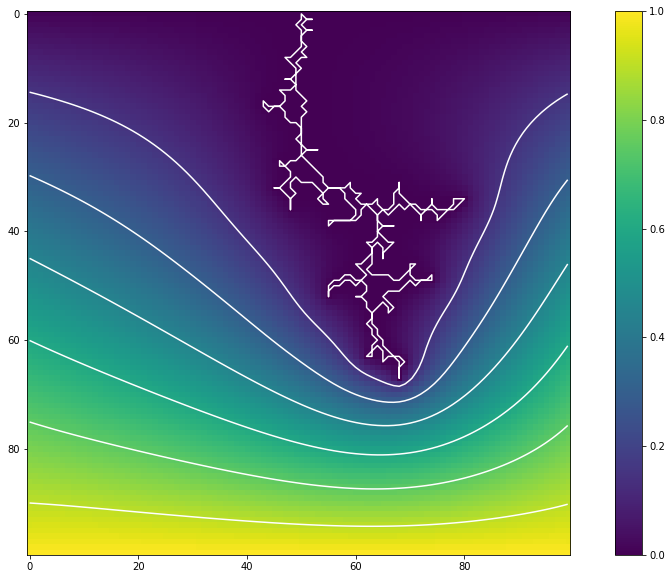

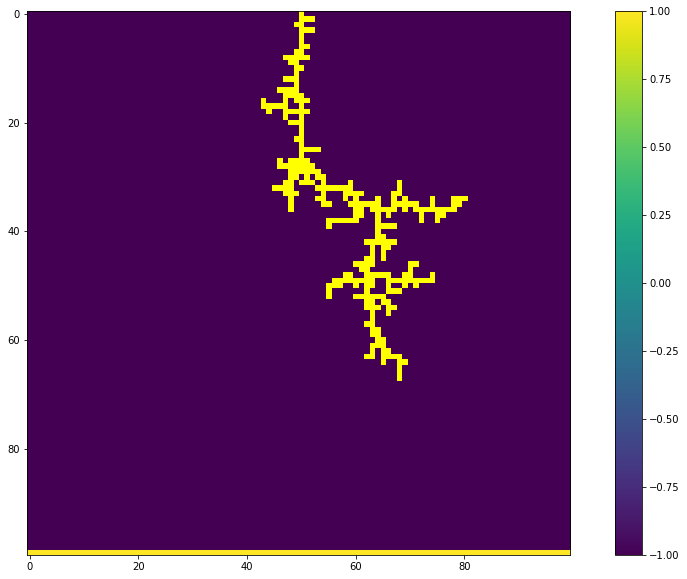

16.12566900253296
0.9195151329040527
0.9460542564047533


In [2]:
sim_instance = lightningSimulation(width=100, height=100, n=1.5)
 
for i in tqdm(range(300)):
    sim_instance.update()

sim_instance.display_state(sim_instance.potential)
sim_instance.display_state(lightning=True)
print(sim_instance.time_spent_potential)
print(sim_instance.time_spent_other)
print(sim_instance.time_spent_potential/(sim_instance.time_spent_other+sim_instance.time_spent_potential))